<a href="https://colab.research.google.com/github/Samreenhabib/Urdu-OCR/blob/main/making_processor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q transformers

In [ ]:
# from transformers import TrOCRProcessor

# processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
# processor.save_pretrained('./ms-processor')

In [ ]:
from transformers import AutoFeatureExtractor, AutoTokenizer
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
feature_extractor = AutoFeatureExtractor.from_pretrained("google/vit-base-patch16-384")
decoder_tokenizer = AutoTokenizer.from_pretrained("urduhack/roberta-urdu-small")
processor =TrOCRProcessor(feature_extractor=feature_extractor, tokenizer=decoder_tokenizer)

In [ ]:
processor.save_pretrained('./processor')

In [ ]:
!pip install -q datasets jiwer

In [ ]:
import pandas as pd
import cv2
df = pd.read_excel('/content/test.xlsx', header=None)
df.rename(columns={0: "file_name", 1: "text"}, inplace=True)
df['text']

0                         ایک پاکستانی نوجوان کی داستان
1                  ایک منفرد انداز میں لکھا گیا سفرنام٘
2                                 قارئین کے لَے تحف خاص
3                                رضوان علی گھمن (جرمنی)
4     خدا نے اس پوری کَاءنات کو بنایا ہے- خدا کی بنا...
5     منفرد ہے- جب آپ نظر اٹھا کر آسمان کی طرف دیکھت...
6     عظمت کی جھلک نظر آتی ہے- سورج چاند ستاروں اور ...
7     صرف پانچ چھ فٹ کا ہوتا ہے لیکن یِہی انسان جب م...
8     میری یہ کہانی بھی عشق کی راہوں میں فنا ہونے وا...
9     معصوم جسم جب ملنے پر آتے ہیں تو اس آگ میں جلنے...
10                                        ہی کا کمال ہے
Name: text, dtype: object

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.3)
# we reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class IAMDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, padding="max_length",max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [ ]:
from transformers import TrOCRProcessor

processor = TrOCRProcessor.from_pretrained("./processor")
train_dataset = IAMDataset(root_dir='/content/image/',
                           df=train_df,
                           processor=processor)
eval_dataset = IAMDataset(root_dir='/content/image/',
                           df=test_df,
                           processor=processor)

In [ ]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 7
Number of validation examples: 4


In [ ]:
encoding = train_dataset[3]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


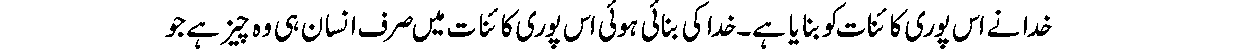

In [ ]:
image = Image.open(train_dataset.root_dir + train_df['file_name'][3]).convert("RGB")
image

In [ ]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

خدا نے اس پوری کَاءنات کو بنایا ہے- خدا کی بنایَ ہویَ اس پوری کانَات میں صرف انسان ہی وہ چیز ہے جو 


In [ ]:
from transformers import VisionEncoderDecoderModel


model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    "google/vit-base-patch16-384", "urduhack/roberta-urdu-small"
)
# set decoder config to causal lm
model.config.decoder.is_decoder = True
model.config.decoder.add_cross_attention = True
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

using steps 

In [ ]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    fp16=True, 
    output_dir="./",
    logging_steps=2,
    save_steps=1000,
    eval_steps=200,
    num_train_epochs=6,  
)

evaluating using epoch

In [ ]:
training_args = Seq2SeqTrainingArguments(
   evaluation_strategy = "epoch",
   learning_rate=2e-4,
   per_device_train_batch_size=2,
   per_device_eval_batch_size=2,
   weight_decay=0.01,
   save_total_limit=3,
   num_train_epochs=6,
   output_dir="./",
   predict_with_generate=True,  
)

In [ ]:
from datasets import load_metric
cer_metric = load_metric("cer")

In [ ]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [ ]:
from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator
)
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 7
  Num Epochs = 6
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 2
  Gradient Accumulation steps = 1
  Total optimization steps = 24


Epoch,Training Loss,Validation Loss,Cer
1,No log,9.447093,2.709877
2,No log,7.128946,1.370370
3,No log,7.455116,1.401235
4,No log,7.845613,1.783951
5,No log,8.057783,2.043210
6,No log,8.179310,2.043210


***** Running Evaluation *****
  Num examples = 4
  Batch size = 2
***** Running Evaluation *****
  Num examples = 4
  Batch size = 2
***** Running Evaluation *****
  Num examples = 4
  Batch size = 2
***** Running Evaluation *****
  Num examples = 4
  Batch size = 2
***** Running Evaluation *****
  Num examples = 4
  Batch size = 2
***** Running Evaluation *****
  Num examples = 4
  Batch size = 2


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=24, training_loss=0.9400688012441, metrics={'train_runtime': 40.4242, 'train_samples_per_second': 1.039, 'train_steps_per_second': 0.594, 'total_flos': 2.2378738933039104e+16, 'train_loss': 0.9400688012441, 'epoch': 6.0})

In [ ]:
trainer.save_model('./trainer')

Saving model checkpoint to ./trainer
Configuration saved in ./trainer/config.json
Model weights saved in ./trainer/pytorch_model.bin
Feature extractor saved in ./trainer/preprocessor_config.json


In [ ]:
model = VisionEncoderDecoderModel.from_pretrained("./trainer")

In [ ]:
image = Image.open('/content/6.png').convert("RGB")

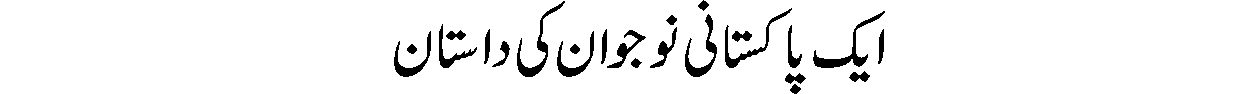

In [ ]:
image

In [ ]:
pixel_values = processor.feature_extractor(image, return_tensors="pt").pixel_values 
print(pixel_values.shape)

torch.Size([1, 3, 384, 384])


In [ ]:
generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_text)

منفرد ہے- جب آپ نظر اٹھا کر آسمان کی طرف دیکھتے ہیں تو آپ کو کاءنات کی اس لامحدود وسعتوں میں خدا کی


In [ ]:
test = Image.open('/content/8.png').convert("RGB")
testvalues = processor.feature_extractor(test, return_tensors="pt").pixel_values 
print(testvalues.shape)

torch.Size([1, 3, 384, 384])


In [ ]:
testids = model.generate(testvalues)
testtext = processor.batch_decode(testids, skip_special_tokens=True)[0]
print(testtext)

منفرد ہے- جب آپ نظر اٹھا کر آسمان کی طرف دیکھتے ہیں تو آپ کو کاءنات کی اس لامحدود وسعتوں میں خدا کی
